In [238]:
from collections import deque

import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [239]:
DIR = "D:\\pool\\20221027_wada\\cbi_10Lmin_1_C001H001S0001\\"

In [240]:
img_0 = cv2.imread("cbi_10_1/cbi_10Lmin_1_C001H001S0001005000.bmp", 1)

In [241]:
hoge_img = cv2.imread("hoge.bmp", 1)

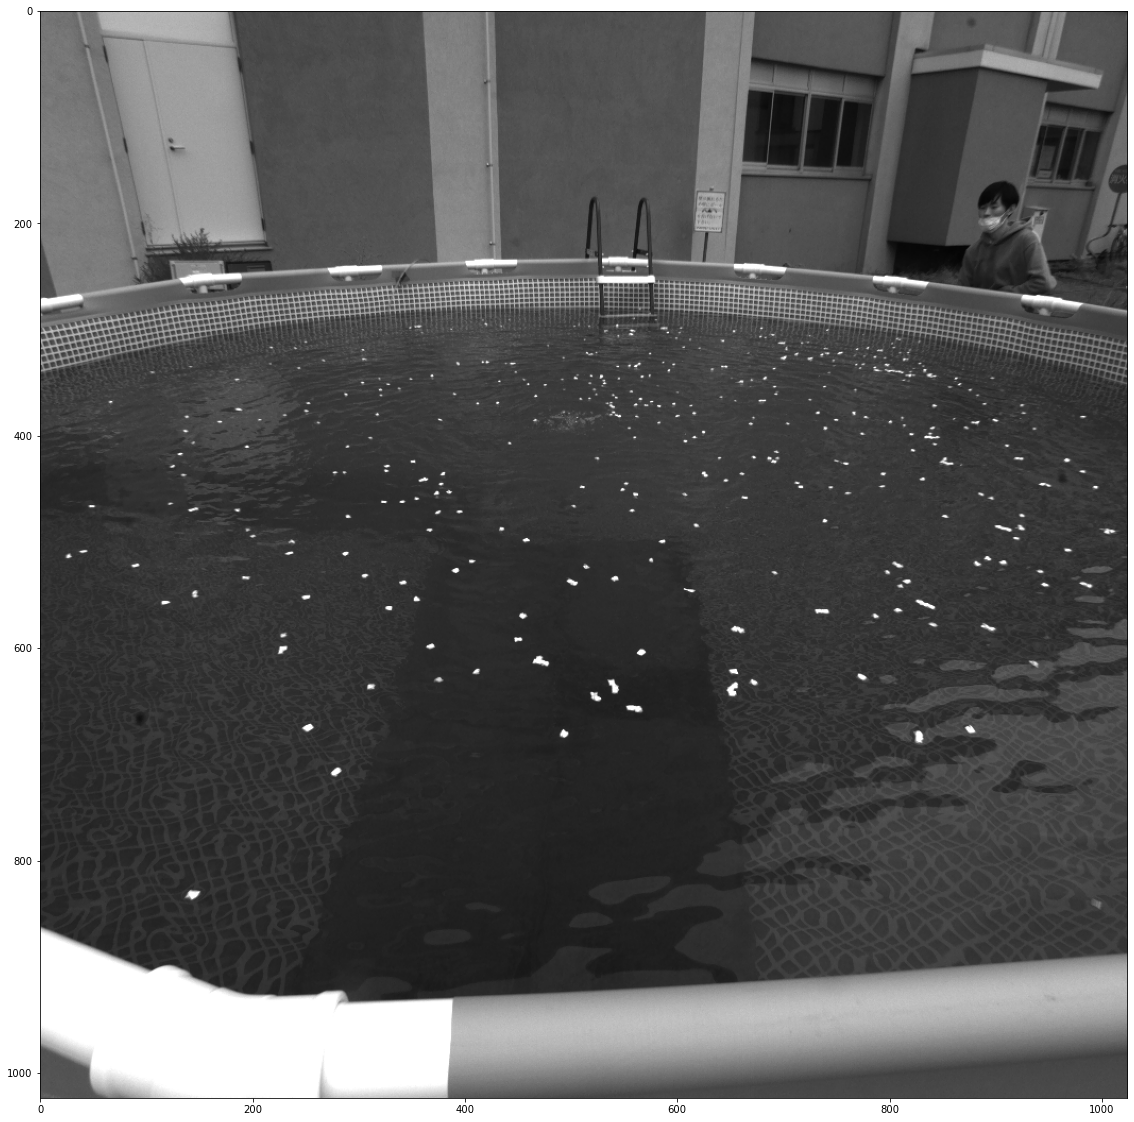

In [242]:
_, ax = plt.subplots(figsize=(20, 20))
ax.imshow(img_0, cmap='gray')

In [243]:
p_original = np.float32([[380, 391], [598, 391], [322, 457], [668, 457]])
p_trans = np.float32([[380, 391], [598, 391], [380, 580], [598, 580]])

In [244]:
M = cv2.getPerspectiveTransform(p_original, p_trans)

In [245]:
img_0_trans = cv2.warpPerspective(img_0, M, (1000, 1000))
hoge_img_trans = cv2.warpPerspective(hoge_img, M, (1000, 1000))

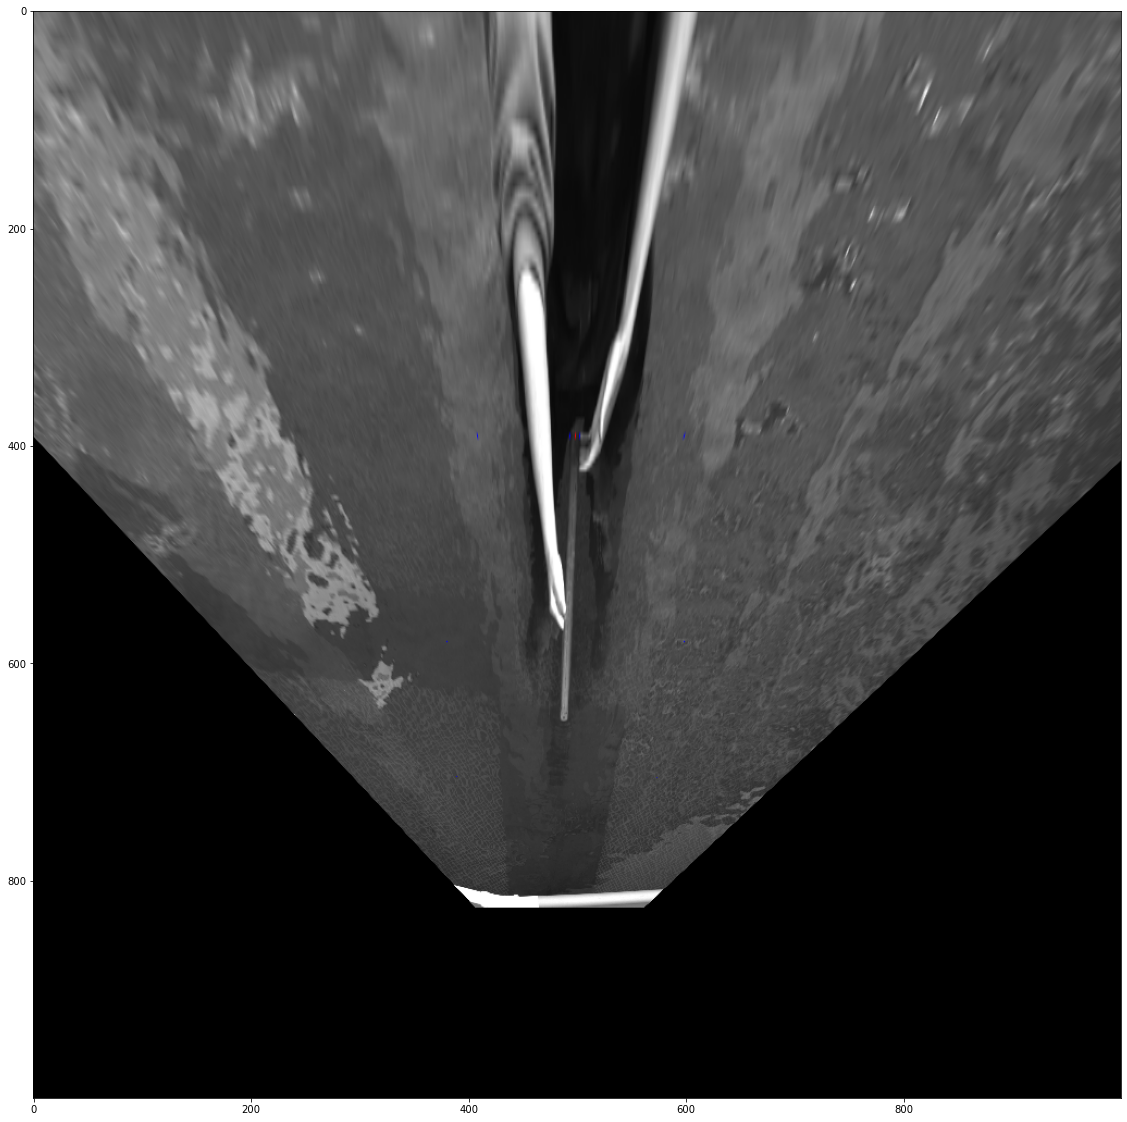

In [246]:
_, ax = plt.subplots(figsize=(20, 20))
ax.imshow(hoge_img_trans, cmap='gray')

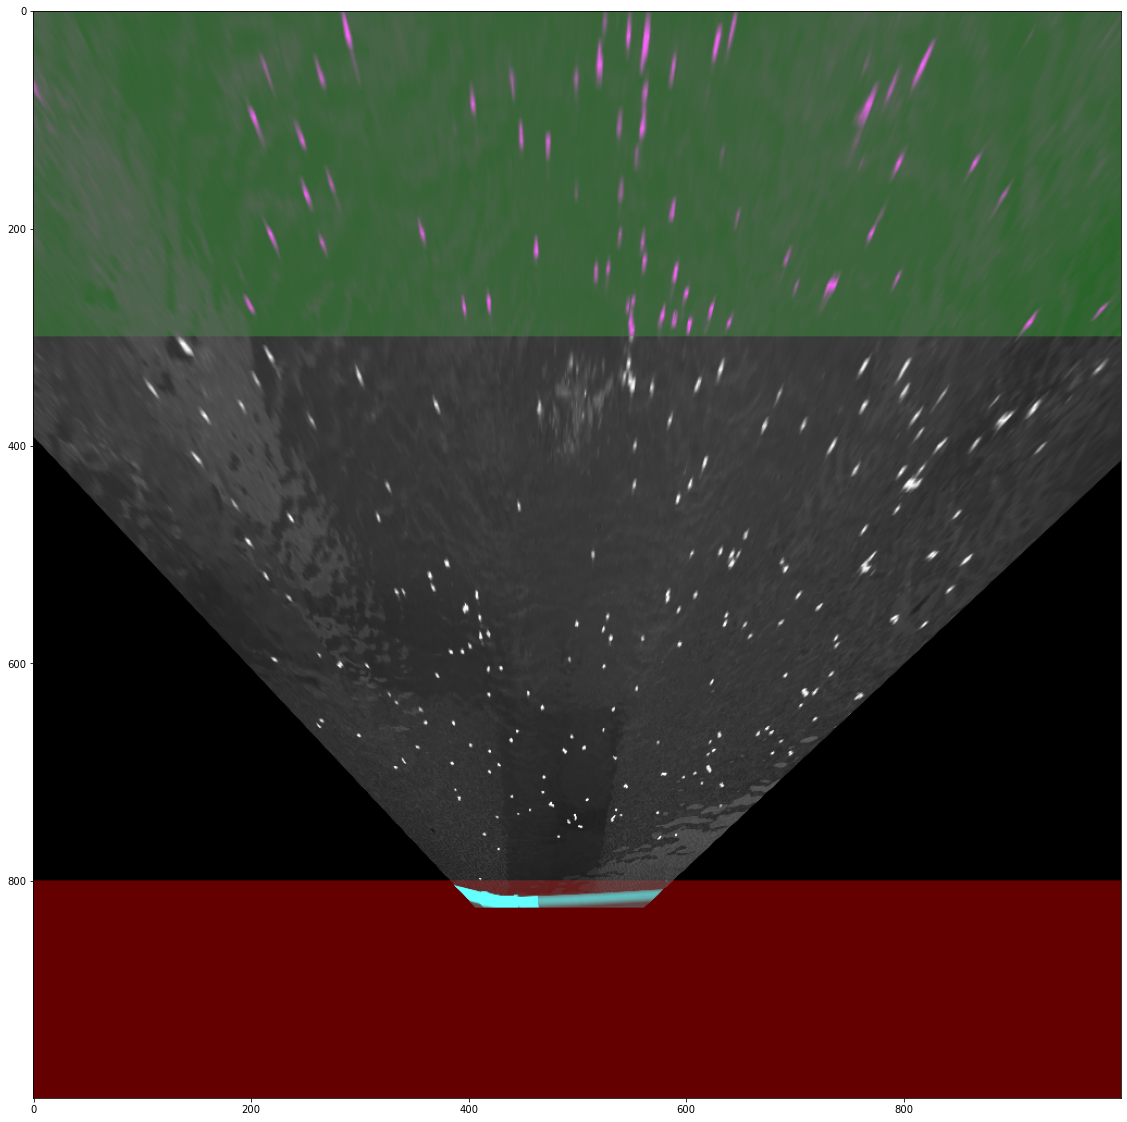

In [247]:
img_0_trans[800:, :, 0] = 100
img_0_trans[:300, :, 1] = 100
_, ax = plt.subplots(figsize=(20, 20))
ax.imshow(img_0_trans, cmap='gray')

In [248]:
_, img_0_trans_th_120 = cv2.threshold(img_0_trans[300:800, :], 160, 255, cv2.THRESH_BINARY)

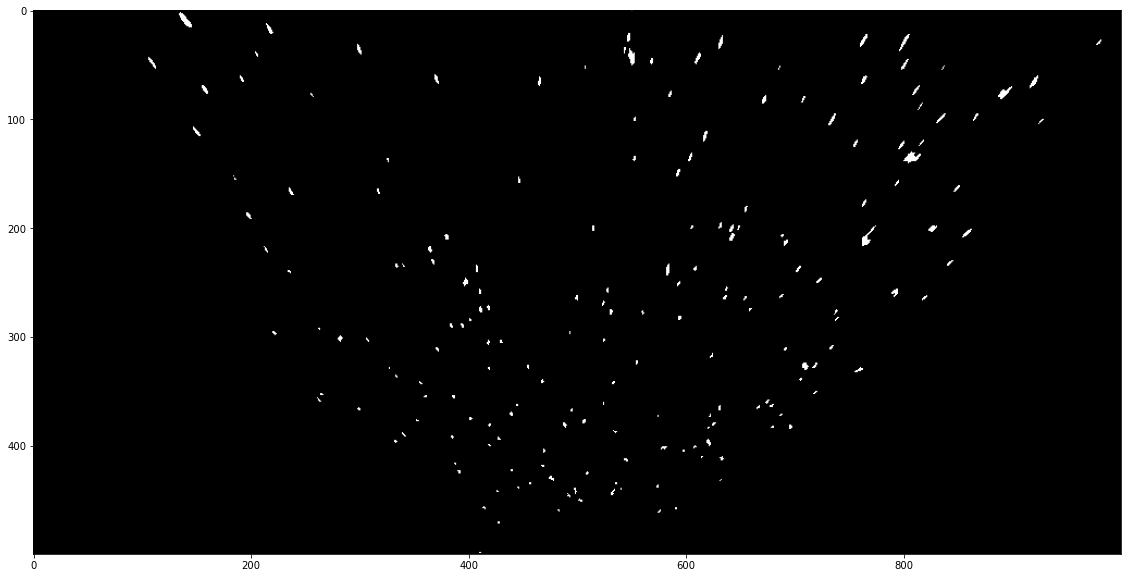

In [249]:
_, ax = plt.subplots(figsize=(20, 10))
ax.imshow(img_0_trans_th_120, cmap='gray')

In [250]:
img_0_trans_th_120 = np.where(img_0_trans_th_120 == (255, 255, 255), (128, 128, 128), (0, 0, 0)).astype(np.uint8)

In [251]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(cv2.cvtColor(img_0_trans_th_120, cv2.COLOR_RGB2GRAY))

In [252]:
for i, j in centroids[1:]:
    img_0_trans_th_120[int(j), int(i), 2] = 255

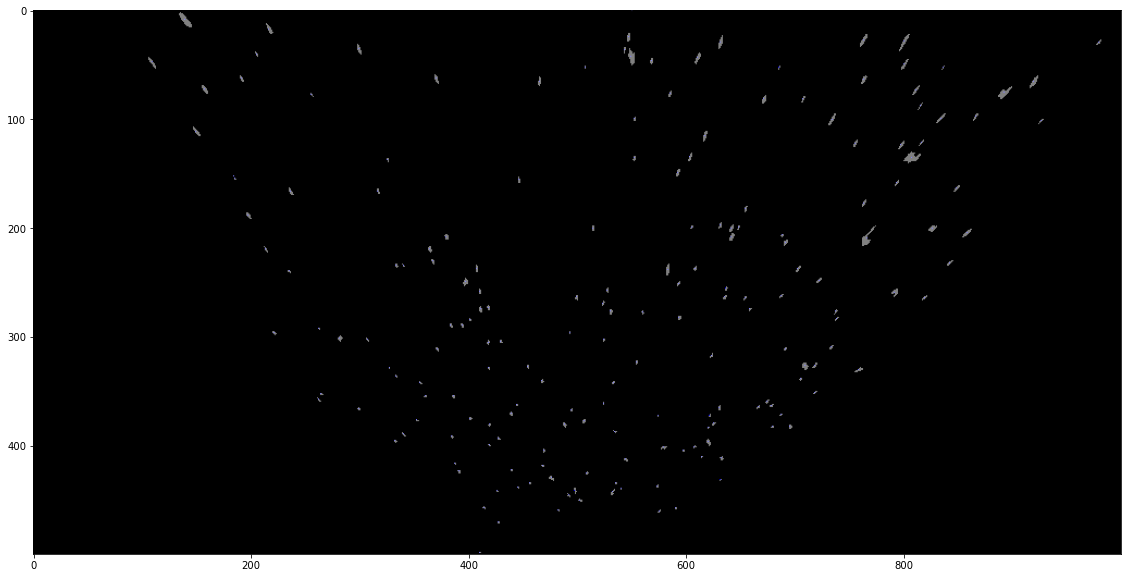

In [253]:
_, ax = plt.subplots(figsize=(20, 10))
ax.imshow(img_0_trans_th_120, cmap='gray')

In [254]:
def preprocessing_2(img):
    img = cv2.warpPerspective(img, M, (1000, 1000))
    _, img = cv2.threshold(img[300:800, :], 160, 255, cv2.THRESH_BINARY)
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img)

    return img, centroids

In [255]:
# for i in tqdm(range(1, 10000)):
#     img, res = preprocessing_2(img=cv2.imread(DIR + "cbi_10Lmin_1_C001H001S0001" + f"{i:06}" + ".bmp", 0))
#     cv2.imwrite(f"img/{i}.png", img)
#     np.savetxt(f"pp4/pp_{i}.csv", res[1:], delimiter=',')

In [256]:
class Vector2D(object):
    def __init__(self, idx):
        self.idx = idx
        self.x = 0.0
        self.y = 0.0


class Gap(object):
    def __init__(self, idx):
        self.idx = idx
        self.gap = 0.0
        self.angle = 0.0


class TP(object):
    def __init__(self, idx):
        self.idx = idx
        self.p0 = 0
        self.p1 = 0
        self.err = 0.0
        self.flag = False


def calc_gap(dx1, dx2):
    gx = Vector2D
    dst = Gap

    gx.x = dx2.x - dx1.x
    gx.y = dx2.y - dx1.y
    dst.gap = np.sqrt(gx.x ** 2 + gx.y ** 2)

    in_prod = dx1.x * dx2.x + dx1.y * dx2.y
    if np.sqrt(dx1.x ** 2 + dx1.y ** 2) * np.sqrt(dx2.x ** 2 + dx2.y ** 2) == 0:
        in_prod /= 1e-8
    else:
        in_prod /= np.sqrt(dx1.x ** 2 + dx1.y ** 2) * np.sqrt(dx2.x ** 2 + dx2.y ** 2)

    if np.abs(in_prod) > 1.0: in_prod /= np.abs(in_prod)

    dst.angle = np.arccos(in_prod)

    out_prod = dx1.x * dx2.y - dx1.y * dx2.x
    if out_prod < 0: dst.angle *= -1

    return dst, in_prod, out_prod


def ptv2t(img):
    pp0, pp1, pp2 = img[0], img[1], img[2]

    if pp0 is None or pp1 is None or pp2 is None:
        return None

    result = np.zeros([pp0.shape[0], 4])

    dx = [Vector2D(idx=x) for x in range(2)]
    dst = [Gap(idx=x) for x in range(1)]
    pp01 = [TP(idx=x) for x in range(pp0.shape[0])]
    s1, s2 = 10, 5  # 1st, 2nd search window
    eta = 15 * np.pi / 180  # criterion on angle
    npa = -1  # the number of available particle
    ntsp = 0  # the number for tracking the same particle

    # 2 times tracking
    for ii in range(pp0.shape[0]):  # Target (= 0th)
        flag = True  # init flag for the particle tracking
        cf, cfc = 1e10, 1e10  # arbitrary large number

        for jj in range(pp1.shape[0]):  # 1st
            dx[0].x = pp1[jj][0] - pp0[ii][0]
            dx[0].y = pp1[jj][1] - pp0[ii][1]

            if np.sqrt(dx[0].x ** 2 + dx[0].y ** 2) <= s1:
                for kk in range(pp2.shape[0]):  # 2nd
                    dx[1].x = pp2[kk][0] - pp1[jj][0]
                    dx[1].y = pp2[kk][1] - pp1[jj][1]

                    dst[0], ip0, op0 = calc_gap(dx[0], dx[1])
                    cfc = dst[0].gap ** 2

                    if dst[0].gap <= s2 and np.abs(dst[0].angle) <= eta and cfc < cf:
                        cf = cfc
                        if flag: npa += 1

                        pp01[npa].p0 = ii
                        pp01[npa].p1 = jj
                        pp01[npa].err = cf
                        pp01[npa].flag = True
                        flag = False

    # post-processing
    # If different particles track the same particle,
    # giving an error flag to particle which has larger error.
    for ii in range(npa):
        if pp01[ii].flag:
            for jj in range(ii + 1, npa):
                if pp01[ii].p1 == pp01[jj].p1:
                    if pp01[ii].err > pp01[jj].err:
                        pp01[ii].flag = False
                        ntsp += 1
                        break
                    else:
                        pp01[jj].flag = False
                        ntsp += 1

    # for debug
    # print(f"The number for tracking the same particle: {ntsp}")
    # print(f"The number of remaining particle by post processing: {npa - ntsp}\n")

    for ii in range(npa):
        if pp01[ii].flag:
            result[ii][0] = pp0[pp01[ii].p0][0]
            result[ii][1] = pp0[pp01[ii].p0][1]
            result[ii][2] = pp1[pp01[ii].p1][0] - pp0[pp01[ii].p0][0]
            result[ii][3] = pp1[pp01[ii].p1][1] - pp0[pp01[ii].p0][1]

    return result[:npa]

In [257]:
data_list = deque([None, None, None])

for n in tqdm(range(1, 30, 10)):
    data_list.popleft()
    tmp = np.loadtxt(f"pp2/pp_{n}.csv", delimiter=',', skiprows=1)
    data_list.append(tmp)

    r = ptv2t(img=data_list)

100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


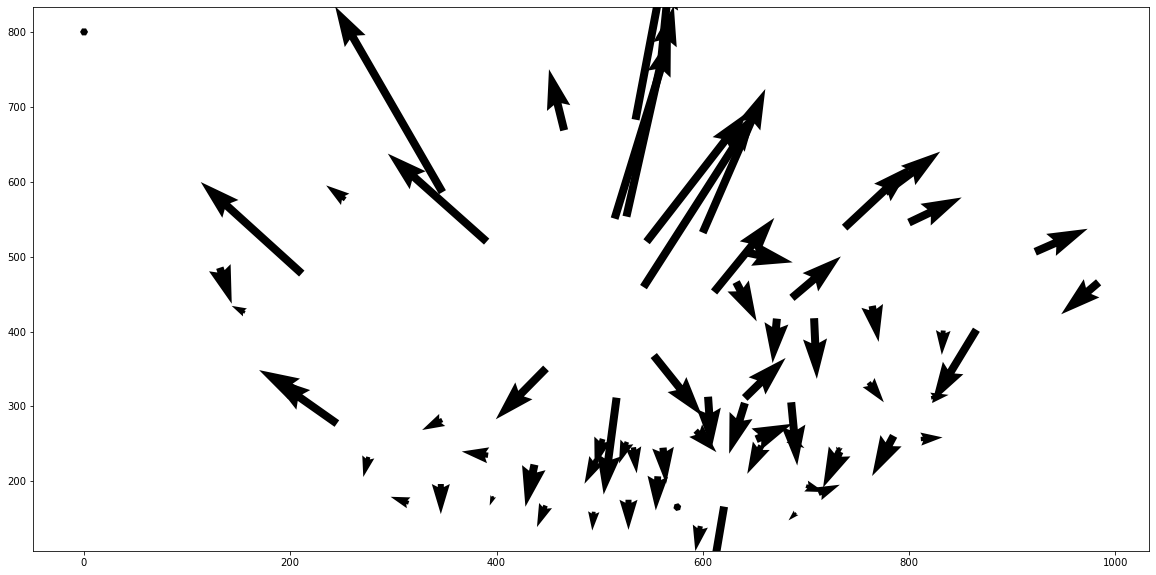

In [258]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.quiver(r[:, 0], 800-r[:, 1], r[:, 2], -r[:, 3])
plt.show()

In [259]:
rr = np.zeros((1, 4))

In [260]:
for t in range(1, 11):
    data_list = deque([None, None, None])

    for n in tqdm(range(t, 10000, 10)):
        data_list.popleft()

        try:
            tmp = np.loadtxt(f"pp4/pp_{n}.csv", delimiter=',', skiprows=1)
        except StopIteration:
            tmp = None

        if tmp is None:
            pass
        elif tmp.ndim == 1:
            if len(tmp) > 0:
                tmp = tmp[np.newaxis, :]
            else:
                tmp = None
        elif tmp.ndim == 2:
            pass
        else:
            tmp = None

        data_list.append(tmp)

        r = ptv2t(img=data_list)
        if r is None:
            pass
        else:
            rr = np.vstack([rr, r])
            np.savetxt(f"ptv3/{n-10}.csv", r, delimiter=',', header="x, y, dx, dy")

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-260-09f9e6783813>:8: UserWarning: loadtxt: Empty input file: "pp4/pp_151.csv"
  tmp = np.loadtxt(f"pp4/pp_{n}.csv", delimiter=',', skiprows=1)
  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-260-09f9e6783813>:8: UserWarning: loadtxt: Empty input file: "pp4/pp_152.csv"
  tmp = np.loadtxt(f"pp4/pp_{n}.csv", delimiter=',', skiprows=1)
  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-260-09f9e6783813>:8: UserWarning: loadtxt: Empty input file: "pp4/pp_153.csv"
  tmp = np.loadtxt(f"pp4/pp_{n}.csv", delimiter=',', skiprows=1)
  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-260-09f9e6783813>:8: UserWarning: loadtxt: Empty input file: "pp4/pp_154.csv"
  tmp = np.loadtxt(f"pp4/pp_{n}.csv", delimiter=',', skiprows=1)
  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-260-09f9e6783813>:8: UserWarning: loadtxt: Empty input file: "pp4/pp_145.csv"
  tmp = np.loadtxt(f"pp4/pp_{n}.csv", delimiter=',', skiprows=1)
  0%|     

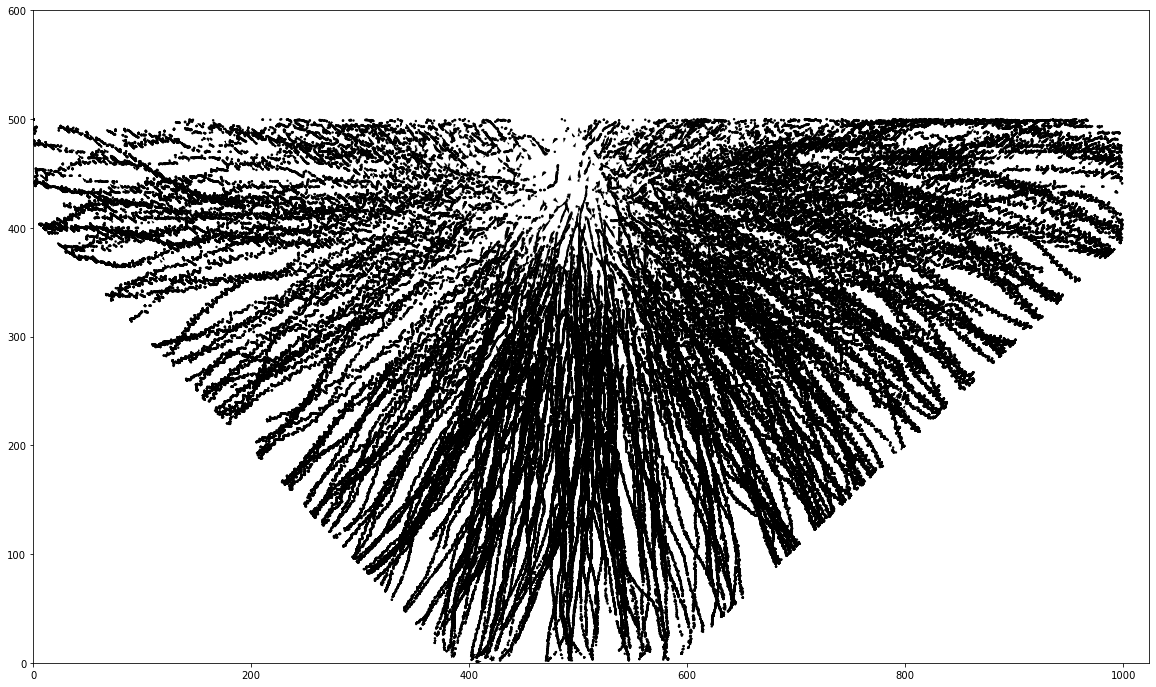

In [261]:
fig, ax = plt.subplots(figsize=(20, 12))
plt.xlim(0, 1024)
plt.ylim(0, 600)
ax.quiver(rr[:, 0], 500-rr[:, 1], rr[:, 2], -rr[:, 3])
plt.show()

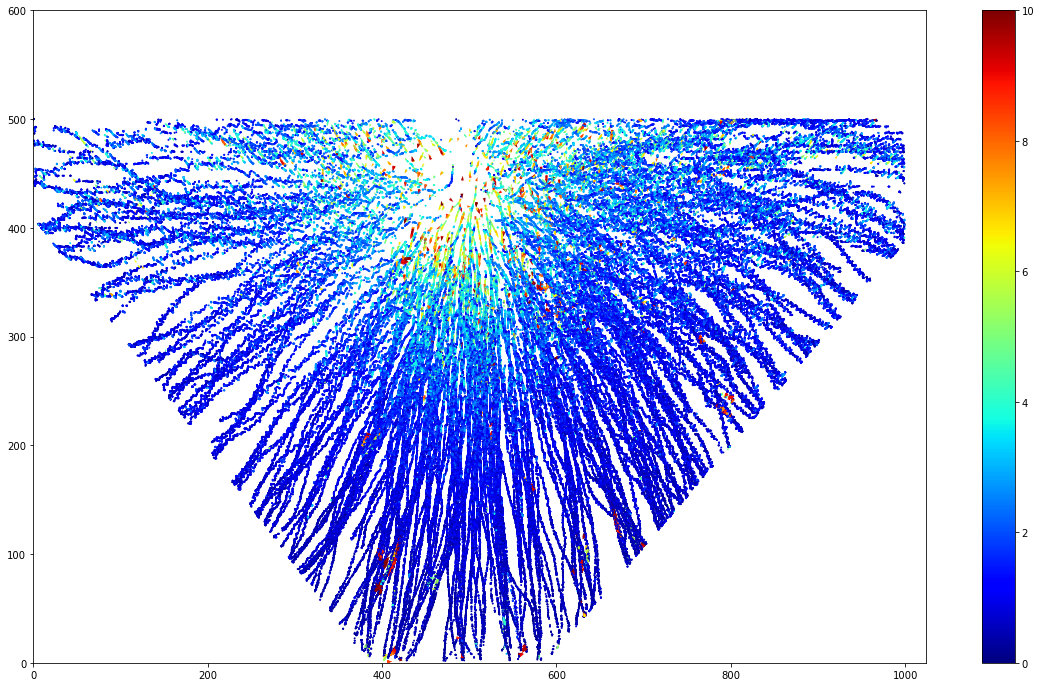

In [262]:
fig, ax = plt.subplots(figsize=(20, 12))
plt.xlim(0, 1024)
plt.ylim(0, 600)
c = ax.quiver(rr[:, 0], 500-rr[:, 1], rr[:, 2], -rr[:, 3], np.sqrt(rr[:, 2]**2 + rr[:, 3]**2), cmap="jet")
fig.colorbar(c)
plt.show()